In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import time
import datetime
from datetime import timedelta
import itertools
from itertools import groupby
from itertools import compress
from operator import truediv
from pyecharts.charts import Bar, Pie, Map, WordCloud, Geo
from pyecharts import options as opts
from pyecharts.globals import ChartType, SymbolType
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from __future__ import unicode_literals
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.commons.utils import JsCode

import import_ipynb
from utils_common import *
from config import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [14]:
# migration data from Baidu Qianxi
# crawlers are in the folder ./baidu_qx
_N2P_PATH_ = './baidu_qx/n2province_rank.csv' # scrapy crawl n2province_rank -o n2province_rank.csv
_P2P_PATH_ = './baidu_qx/p2province_rank.csv' ###### scrapy crawl p2province_rank -o p2province_rank.csv
# travel size index: national
_NIndex_PATH_ = './baidu_qx/nhistory_curve.csv' # scrapy crawl nhistory_curve -o nhistory_curve.csv
# travel size index: provincial
_Index_PATH_ = './baidu_qx/history_curve.csv' ####### scrapy crawl history_curve -o history_curve.csv
# internal flow: city
_IF_PATH_ = './baidu_qx/internal_flow.csv' ####### scrapy crawl internal_flow -o internal_flow.csv
# # Where to save the figures
_Figure_PATH_ = './figures/'

In [28]:
# 迁徙规模指数：全国为总体迁徙规模，不区分迁入或迁出；城市级区分迁入或迁出
# Get the travel size index: national (does not distinguish between move in and move out)
def load_NIndex_raw():
    raw = pd.read_csv(_NIndex_PATH_)
    data = raw[raw.inOrout == 'move_in']
    data = data[['date', 'value']]
    rename_dict = {'date': 'update_date',
                    'value': 'value',
                  }
    data = data.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    return data

# 迁徙规模指数：反映迁入或迁出人口规模，省或城市间可横向对比
# Get the travel size index: provincial (does distinguish between move in and move out)
def load_Index_raw():
    raw = pd.read_csv(_Index_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'province_name': 'province_name',
                    'value': 'value',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name', 'province_name_en', 'value']
    data = data[new_col]
    return data

# Get the travel size ratio: from nation to province or from province to nation
# examples:
# 01月01日， 全国热门迁入地（目的地）是：广东省，迁入人口数量占全国迁入人口总量的13.67%
# 01月01日， 全国热门迁出地（出发地）是：广东省，迁出人口数量占全国迁出人口总量的14.98% 
def load_N2P_raw():
    raw = pd.read_csv(_N2P_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'province_name': 'province_name',
                   'value': 'ratio',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date  
    # the ratio is a percentage
    data['value'] = data.apply(lambda row: data_NIndex[data_NIndex.update_date == row.update_date].value.tolist()[0]*row.ratio/100, axis=1)
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name', 'province_name_en', 'value', 'ratio']
    data = data[new_col]
    
    # display some basic information
    print('Last update: ', data['update_date'].max())
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

# Get the travel size ratio: from province to province
# examples:
# 01月01日，迁入北京人口主要来源地为：河北省，占北京迁入人口总量的50.40%
# 01月01日，北京迁出人口主要目的地为：河北省，占北京迁出人口总量的46.19% 
def load_P2P_raw():
    raw = pd.read_csv(_P2P_PATH_)
    rename_dict = {'date': 'update_date',
                   'inOrout': 'direction',
                   'inOrout_province_name': 'province_name_io',
                   'province_name': 'province_name',
                   'value': 'ratio'
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date
    # there are two methods to calculate the travel size value:
    # 1. using national travel size index and n2p travel size ratio
    # 2. using provincial travel size index and p2p travel size ratio
    # method 1 has severe leakage problem (which has been commented below)
    # method 2 is more preferred
    #data['nvalue'] = data.apply(lambda row: data_N2P[(data_N2P.update_date == row.update_date) & (data_N2P.direction == row.direction) & (data_N2P.province_name == row.province_name)].value.tolist()[0]*row.ratio/100, axis=1)
    data['value'] = data.apply(lambda row: data_Index[(data_Index.update_date == row.update_date) & (data_Index.direction == row.direction) & (data_Index.province_name == row.province_name)].value.tolist()[0]*row.ratio/100, axis=1)
    data = add_en_location(data, tag = 'province')
    new_col = ['update_date', 'direction', 'province_name_io', 'province_name', 'province_name_en', 'value', 'nvalue', 'ratio']
    new_col = ['update_date', 'direction', 'province_name_io', 'province_name', 'province_name_en', 'value', 'ratio']
    data = data[new_col]
    
    print('Last update: ', data['update_date'].max())
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

# Compare method 1 and method 2
# Figure out whether the indexs are consistent and whether there exists any data leakage
# temp = data_P2P
def consistency_P2P(temp):
    provinces = data_Index.province_name.drop_duplicates().tolist()
    nerror_list = []
    error_list = []
    for i in range(0, len(provinces)):
        for j in range(i+1,len(provinces)):
            p, q = provinces[i], provinces[j]
            temp_in = temp[(temp.direction == 'move_in') & (temp.province_name == p) & (temp.province_name_io == q)]
            temp_out = temp[(temp.direction == 'move_out') & (temp.province_name == q) & (temp.province_name_io == p)]
            nerror = list(map(truediv, temp_in.nvalue.tolist(), temp_out.nvalue.tolist()))
            nerror = sum(nerror)/temp_in.shape[0]
            error = list(map(truediv, temp_in.value.tolist(), temp_out.value.tolist()))
            error = sum(error)/temp_in.shape[0]
            if abs(nerror - 1) > 5e-2:
                print(p, q, nerror)
            if abs(error - 1) > 5e-2:
                print(p, q, error)
            nerror_list.append(nerror)
            error_list.append(error)
    return nerror_list, error_list

# The conclusion is:
# Choose value instead of nvalue 
# Remove 西藏自治区 # Pay attention to 新疆维吾尔自治区 宁夏回族自治区 青海省

# Create the P2P migration network
def network_P2P(temp):
    data = pd.DataFrame(columns=['update_date', 'source', 'target', 'value'])
    data['update_date'] = temp.update_date
    data['source'] = temp.apply(lambda row: row.province_name_io if row.direction == 'move_in' else row.province_name, axis=1)
    data['target'] = temp.apply(lambda row: row.province_name if row.direction == 'move_in' else row.province_name_io, axis=1)
    data['value'] = temp.value
    data = data[(data.source!='西藏自治区') & (data.target!='西藏自治区')] # remove
    # take the average (for every edge, we have two weights, one from move in and the other from move out)
    data = data.groupby(['update_date', 'source', 'target']).mean().reset_index() 
    data = add_en_location(data, tag = 'network')
    new_col = ['update_date', 'source', 'source_en', 'target', 'target_en', 'value']
    data = data[new_col]
    data.to_csv(r'./data/data_network_P2P.csv', index = False)
    return data

In [29]:
# Get the internal flow data
def load_IF_raw():
    # know which province a city belongs to via their zip codes
    def from_city_to_province(row):
        city_zipcode = [k for k,v in city_dict.items() if v == row.city_name][0]
        province_zipcode = city_zipcode[0:2] + '0000'
        province_name = province_dict[province_zipcode]
        return province_name
    raw = pd.read_csv(_IF_PATH_)
    rename_dict = {'date': 'update_date','value': 'ratio'}
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'], format ='%Y%m%d')  
    data['update_date'] = data['update_date'].dt.date 
    data['province_name'] = data.apply(lambda row: from_city_to_province(row), axis = 1)
    data = data[~data.province_name.isin(['香港','澳门','台湾省', '西藏自治区'])]
    data['population'] = data.apply(lambda row: city_population_dict[row.city_name], axis = 1)
    data['value'] = data.apply(lambda row: row.ratio*row.population, axis = 1)
    # summing up to the provincial level
    data_province = data.groupby(['update_date', 'province_name'])["population", "value"].apply(lambda x : x.sum()).reset_index()
    # n stands for normalization
    data_province['n_value'] = data_province.apply (lambda row: row.value/row.population, axis=1)
    data_province = add_en_location(data_province, tag = 'province')
    new_col = ['update_date', 'province_name', 'province_name_en', 'population', 'value', 'n_value']
    data_province = data_province[new_col]
    data_province = data_province.sort_values(by = ['update_date', 'province_name_en'])
    data = data.sort_values(by = ['update_date'])
    return data, data_province

In [30]:
# Compress warnings: everyone will be tired of warnings (pretend that they do not exist...)
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")
# Plot the migration index: national, provincial (move in), and provincial (move out)
def figure_index(df, fs, subject = 'China'):
    df = df[df['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df = df.reset_index(drop = True)
    if subject == 'China': # sum of provincial migration index
        df = df.groupby('update_date')['value'].sum()
        df = df.reset_index()
    elif subject == 'Hubei (move in)':
        df = df[(df['direction'] == 'move_in') & (df['province_name_en'] == 'Hubei')]
        df = df.reset_index(drop = True)
    elif subject == 'Hubei (move out)':
        df = df[(df['direction'] == 'move_out') & (df['province_name_en'] == 'Hubei')]
        df = df.reset_index(drop = True)
        
    timespan = (max(df.update_date) - min(df.update_date)).days + 1
    # before the quarantine
    T = (datetime.date(int(2020),int(1),int(21)) - min(df.update_date)).days + 1
    # during the quarantine
    TT = (datetime.date(int(2020),int(1),int(31)) - min(df.update_date)).days + 1
    TTT = (datetime.date(int(2020),int(2),int(21)) - min(df.update_date)).days + 1
    
    first_list = [True]*T + [False]*(timespan - T)
    second_list = [False]*TT + [True]*(TTT - TT) + [False]*(timespan - TTT)
    first_mean = np.mean(np.multiply(df.value.tolist(), first_list))*timespan/T
    second_mean = np.mean(np.multiply(df.value.tolist(), second_list))*timespan/(TTT - TT)
    first_index = [first_mean]*timespan
    second_index = [second_mean]*timespan
    
    fig = plt.figure(figsize = (12, 5))
    ax = plt.subplot(111)
    sns.set_style('whitegrid')
    palette = plt.get_cmap('bone_r')
    y_min, y_max = np.round(min(df.value), 1)*0.95, np.round(max(df.value), 1)*1.05
    ax.scatter(df['update_date'], df['value'],marker = 'o', 
               color = [rgb2hex(palette(temp/y_max + 0.15)) for temp in df['value'].tolist()],
               label = None)
    ax.plot(df['update_date'], df['value'], linewidth = 2, color = palette(0.5), label = None)
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.plot(list(compress(df['update_date'], first_list)), list(compress(first_index, first_list)), 
            linewidth = 2, color = palette(first_mean/y_max + 0.05), label = 'average plateau')
    ax.plot(list(compress(df['update_date'], second_list)), list(compress(second_index, second_list)), 
            linewidth = 2, color = palette(second_mean/y_max + 0.05), label = 'lockdown plateau')
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # matplotlib.patch.Patch properties
    props_first = dict(boxstyle = 'round', facecolor = palette(first_mean/y_max + 0.05), alpha = 0.5)
    props_second = dict(boxstyle = 'round', facecolor = palette(second_mean/y_max + 0.05), alpha = 0.5)
    
    if y_min <= 0.5:
        ax.set_ylim(-0.5, y_max)
    else:
        ax.set_ylim(y_min, y_max)
    
    shift = 0.3
    
    # place two text boxes
    ax.text(0/timespan + 0.03, (first_mean - y_min)/(y_max - y_min) - shift,
            'average plateau: ' + str(round(first_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_first)
    ax.text(TT/timespan + 0.03, (second_mean - y_min)/(y_max - y_min) + shift,  # - 0.25, - 0.1
            'average plateau: ' + str(round(second_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_second)
    ax.set_title(subject + ': migration index (' + str(round(second_mean/first_mean*100, 2)) + '%)', fontsize = fs + 2) 
    ax.set_xlabel('Date', fontsize = fs)
    ax.set_ylabel('Index', fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    subject = subject.replace("(","")
    subject = subject.replace(")","")
    fig.savefig(_Figure_PATH_ + subject.replace(" ", "_") + '_MI.png', dpi = 400)

In [18]:
# From the above conclusion: method 1 🌝 method 2 🌚
# Get the travel size index: national
#data_NIndex = load_NIndex_raw() 
#list_0 = data_NIndex.value.tolist()
# Get the travel size index: provincial
data_Index = load_Index_raw()
# Verify that there is hardly any data leakage
list_1 = data_Index[(data_Index.direction == 'move_in')].groupby('update_date').agg('sum').value.tolist()
list_2 = data_Index[(data_Index.direction == 'move_out')].groupby('update_date').agg('sum').value.tolist()
#list(map(truediv, list_0, list_1)) # agree? no
#list(map(truediv, list_1, list_2)) # agree? yes

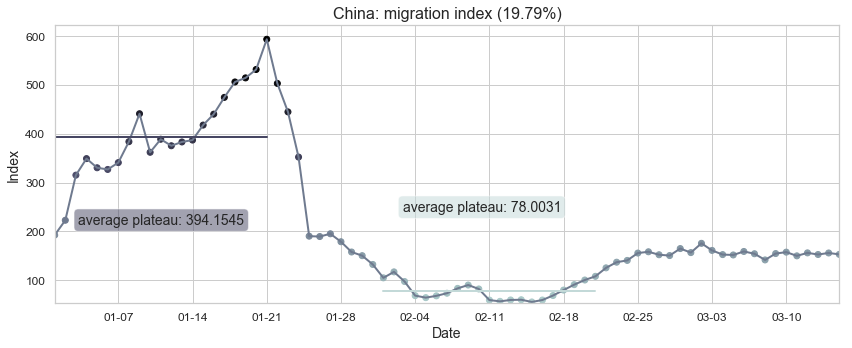

In [20]:
# national migration index
figure_index(data_Index, fs = 14, subject = 'China')

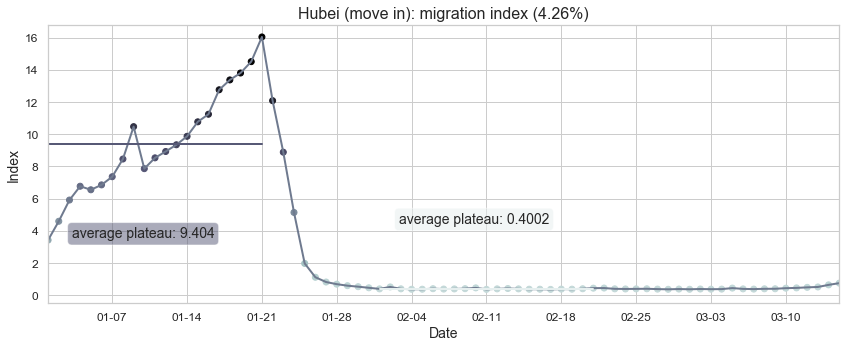

In [24]:
# provincial migration index (move in)
figure_index(data_Index, fs = 14, subject = 'Hubei (move in)')

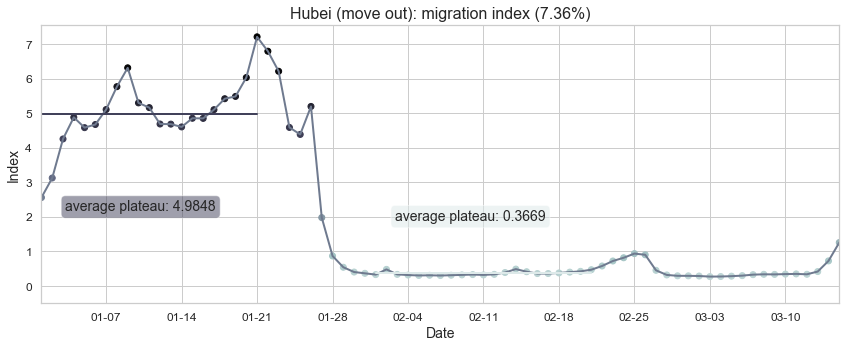

In [25]:
# provincial migration index (move out)
figure_index(data_Index, fs = 14, subject = 'Hubei (move out)')

In [31]:
# From the above conclusion: method 1 🌚 method 2 🌝 
# method 1
# Get the travel size ratio: n2p
# examples:
# 01月01日， 全国热门迁入地（目的地）是：广东省，迁入人口数量占全国迁入人口总量的13.67% 
# 2020-01-01	move_in	广东省	Guangdong	13.67
# 01月01日， 全国热门迁出地（出发地）是：广东省，迁出人口数量占全国迁出人口总量的14.98%
# 2020-01-01	move_out	广东省	Guangdong	14.98
#data_N2P = load_N2P_raw()

In [32]:
# method 2
# Get the travel size ratio: p2p
# 01月01日，迁入新疆人口主要来源地为：甘肃省，占新疆迁入人口总量的 14.89%
data_P2P = load_P2P_raw()
# the index of province A move in province B (from B to A) should be equal (at least close to) 
# that of province B move out province A (from B to A)
# examples proving the above statement
#temp_in = data_P2P[(data_P2P.direction == 'move_in') & (data_P2P.province_name == '新疆维吾尔自治区') & (data_P2P.province_name_io == '甘肃省')]
#temp_out = data_P2P[(data_P2P.direction == 'move_out') & (data_P2P.province_name == '甘肃省') & (data_P2P.province_name_io == '新疆维吾尔自治区')]
#[(x+y)/2 for x,y in zip(*[temp_in, temp_out])][:10]

Last update:  2020-03-10
Data date range:  2020-01-01 to 2020-03-10
Number of rows in raw data:  129012


In [33]:
data_network_P2P = network_P2P(data_P2P)

In [34]:
# Chunyun 2020: from January 10 to February 18
# the travel size of Chunyun from wikipedia
# 14.76 unit = 亿人次 https://zh.wikipedia.org/wiki/%E6%98%A5%E8%BF%90
# the travel size of Chunyun from Baidu Qianxi
# compare these numbers to deduce the unit of data from Baidu Qianxi
# 10603 unit = 十万人次
#nation_migration = {"20200110":438.973668,"20200111":481.0020084,"20200112":446.3765172,"20200113":436.1630004,"20200114":412.6136436,"20200115":431.4138732,"20200116":450.4974408,"20200117":479.9456712,"20200118":529.5260304,"20200119":525.4227648,"20200120":542.3144724,"20200121":621.2109996,"20200122":580.6973268,"20200123":551.6447328,"20200124":448.30989,"20200125":261.5466672,"20200126":287.4244176,"20200127":264.7354104,"20200128":225.8917632,"20200129":192.6017028,"20200130":183.7748412,"20200131":153.6096312,"20200201":130.643928,"20200202":142.4592036,"20200203":117.190152,"20200204":85.9585284,"20200205":81.3802464,"20200206":81.188244,"20200207":85.798116,"20200208":94.7500092,"20200209":111.1956336,"20200210":100.9839312,"20200211":74.7511092,"20200212":71.3811852,"20200213":73.1563812,"20200214":73.4141556,"20200215":70.6802436,"20200216":73.5190992,"20200217":92.2017168,"20200218":96.6906396}
#sum(nation_migration.values())

In [47]:
# 9134 unit = 十万人次
data_P2P_chunyun = data_P2P[(data_P2P.update_date >= datetime.date(int(2020),int(1),int(10))) & (data_P2P.update_date <= datetime.date(int(2020),int(2),int(18)))]
chunyun_in, chunyun_out = sum(data_P2P_chunyun[data_P2P_chunyun.direction == 'move_in'].value), sum(data_P2P_chunyun[data_P2P_chunyun.direction == 'move_out'].value)
chunyun_in, chunyun_out, chunyun_in + chunyun_out

(4569.8991980288365, 4569.843078672511, 9139.742276701349)

In [36]:
# What the minimal value would be if we remove 宁夏回族自治区，西藏自治区，新疆维吾尔自治区，甘肃省 and 青海省from the data set
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='宁夏回族自治区') & (data_P2P.province_name!='宁夏回族自治区')]
#data_P2P_x = data_P2P[(data_P2P.province_name_io!='西藏自治区') & (data_P2P.province_name!='西藏自治区')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='新疆维吾尔自治区') & (data_P2P.province_name!='新疆维吾尔自治区')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='甘肃省') & (data_P2P.province_name!='甘肃省')]
#data_P2P_x = data_P2P_x[(data_P2P.province_name_io!='青海省') & (data_P2P.province_name!='青海省')]
#data_P2P_x.loc[data_P2P_x.value.idxmin()]

In [37]:
data_if_city, data_if = load_IF_raw()

In [38]:
data_if_nation = data_if.groupby(['update_date'])["population", "value"].apply(lambda x : x.sum()).reset_index()
data_if_nation['n_value'] = data_if_nation.apply (lambda row: row.value/row.population, axis=1)

In [59]:
# Plot the internal flow index: national, provincial (Hubei), and city level (Wuhan)
def figure_if(df, subject, fs = 12):
    df = df[df['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df = df.reset_index(drop = True)
    fig = plt.figure(figsize = (12, 5))
    ax = plt.subplot(111)
    sns.set()
    timespan = (max(df.update_date) - min(df.update_date)).days + 1
    T = (datetime.date(int(2020),int(1),int(21)) - min(df.update_date)).days + 1
    TT = (datetime.date(int(2020),int(1),int(31)) - min(df.update_date)).days + 1
    TTT = (datetime.date(int(2020),int(2),int(21)) - min(df.update_date)).days + 1
    first_list = [True]*T + [False]*(timespan - T)
    second_list = [False]*TT + [True]*(TTT - TT) + [False]*(timespan - TTT)
    first_mean = np.mean(np.multiply(df.n_value.tolist(), first_list))*timespan/T
    second_mean = np.mean(np.multiply(df.n_value.tolist(), second_list))*timespan/(TTT - TT)
    y_min, y_max = np.round(min(df.n_value), 1)*0.95, np.round(max(df.n_value), 1)*1.05
    first_index = [first_mean]*timespan
    second_index = [second_mean]*timespan
    palette = plt.get_cmap('bone_r')
    ax.scatter(df['update_date'], df['n_value'],
               marker = 'o', 
               color = [rgb2hex(palette(temp/5)) for temp in df['n_value'].tolist()],
               label = None)
    ax.plot(df['update_date'], df['n_value'], linewidth = 2,
            color = palette(0.5), label = None)
    ax.plot(list(compress(df['update_date'], first_list)), list(compress(first_index, first_list)), 
            linewidth = 2, color = palette(first_mean/7), label = 'average plateau')
    ax.plot(list(compress(df['update_date'], second_list)), list(compress(second_index, second_list)), 
            linewidth = 2, color = palette(second_mean/7), label = 'lockdown plateau')
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # these are matplotlib.patch.Patch properties
    props_first = dict(boxstyle = 'round', facecolor = palette(first_mean/10), alpha = 0.5)
    props_second = dict(boxstyle = 'round', facecolor = palette(second_mean/10), alpha = 0.5)
    ax.set_ylim(np.round(min(df.n_value), 1) - 0.2, np.round(max(df.n_value), 1) + 0.2)
    shift = 0.25
    
    # place two text boxes
    ax.text(0/timespan + 0.03, (first_mean - y_min)/(y_max - y_min) - shift,
            'average plateau: ' + str(round(first_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_first)
    ax.text(TT/timespan + 0.03, (second_mean - y_min)/(y_max - y_min) + shift,  # - 0.25, - 0.1
            'average plateau: ' + str(round(second_mean, 4)), 
            transform = ax.transAxes, fontsize = fs,
            verticalalignment = 'center', bbox=props_second)
    ax.set_title(subject + ': internal flow ratio (' + str(round(second_mean/first_mean*100, 2)) + '% contact rate)', fontsize = fs + 2) 
    ax.set_xlabel('Date', fontsize = fs)
    ax.set_ylabel('Ratio', fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    fig.savefig(_Figure_PATH_ + subject + '_IF.png', dpi = 400)

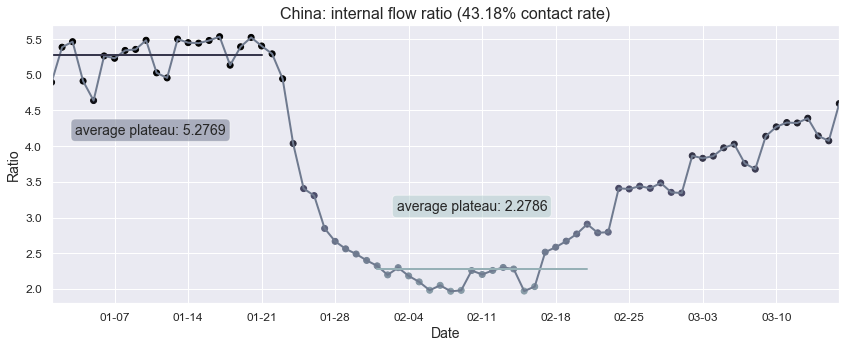

In [60]:
figure_if(data_if_nation, 'China', 14)

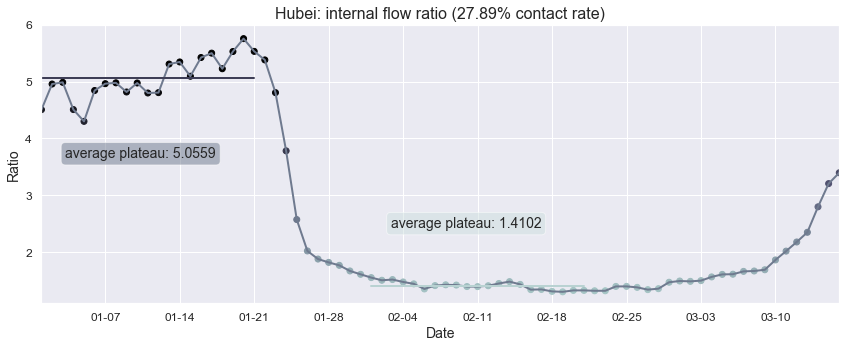

In [63]:
data_if_Hubei = data_if[data_if['province_name_en'] == 'Hubei']
data_if_Hubei = data_if_Hubei.reset_index(drop = True)
figure_if(data_if_Hubei, 'Hubei', 14)

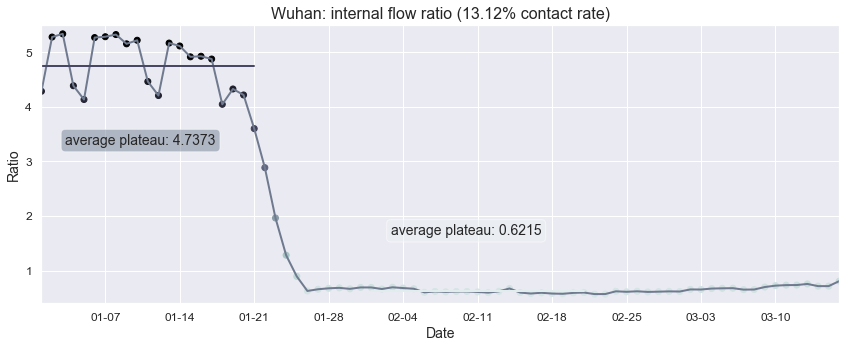

In [62]:
data_if_Wuhan = data_if_city[data_if_city['city_name'] == '武汉市']
data_if_Wuhan = data_if_Wuhan.reset_index(drop = True)
data_if_Wuhan['n_value'] = data_if_Wuhan['ratio']
figure_if(data_if_Wuhan, 'Wuhan', 14)

In [66]:
date_initial = datetime.date(int(2020),int(1),int(7))
date_tr = datetime.date(int(2020),int(3),int(10))
data_if_province = data_if[(data_if.update_date >= date_initial) & (data_if.update_date <= date_tr)]

In [71]:
# Plot the internal flow index: provincial (every province)
def figure_IF(df, fsize= (10, 6), fs = 16, title = 'City migration'):
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style("ticks")
    palette = plt.get_cmap('bone')
    i = 0
    for key, grp in df.groupby(['province_name_en']):
        if key!='Hubei':
            ax = grp.plot(ax = ax, x='update_date', y='n_value', style = '-', color = palette(i/50 + 0.2), label = key)
        else:
            ax = grp.plot(ax = ax, x='update_date', y='n_value', style = '-', marker = 'o', color = palette(i/50 + 0.2), label = key)
        i += 1
    plt.legend(loc='upper center', ncol = 6, fancybox = True, fontsize = fs - 5)
    ax.set_xlabel("Date", fontsize = fs - 2)
    ax.set_ylabel("Normalized internal flow index", fontsize = fs - 2)
    ax.set_title('Mainland China: Provincial internal flow', fontsize = fs)
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    fig.savefig(_Figure_PATH_ + 'China_Province_IF.png', dpi = 400)
    plt.show()

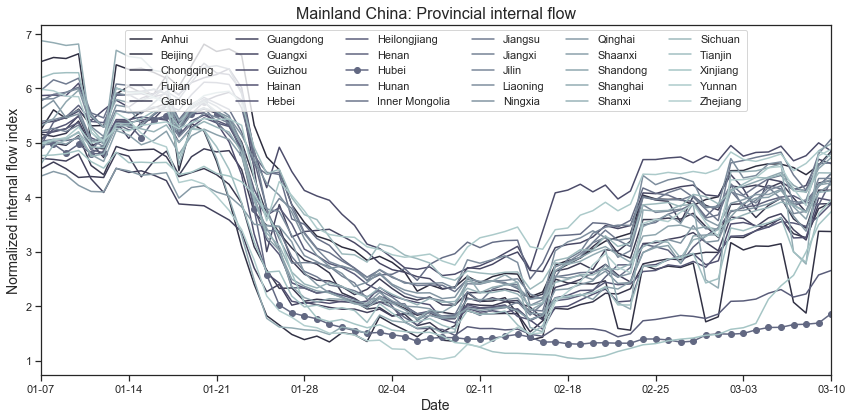

In [72]:
figure_IF(df = data_if_province, fsize= (12, 6), fs = 16, title = 'City migration')

In [75]:
#data_if_single = data_if_city[data_if_city.update_date == datetime.date(int(2020),int(1),int(31))]
#data_if_single = data_if_single[data_if_single.province_name == '湖北省']
#data_if_single.sort_values(by = 'population')